In [1]:
import numpy as np
import panel as pn
import pandas as pd
import hvplot.pandas
import seaborn as sns
import matplotlib_inline
import ipywidgets as widgets
import plotly.express as px
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.legend import Legend

pn.extension('tabulator')

# Data cleaning and preparation

### Reading the data from the csv file

In [2]:
raw_df = pd.read_csv('Hospital ER.csv')
raw_df.head()

,date,patient_id,patient_gender,patient_age,patient_sat_score,patient_first_inital,patient_last_name,patient_race,patient_admin_flag,patient_waittime,department_referral
0,2020-03-20 08:47:01,145-39-5406,M,69,10.0,H,Glasspool,White,False,39,NaN
1,2020-06-15 11:29:36,316-34-3057,M,4,NaN,X,Methuen,Native American/Alaska Native,True,27,NaN
2,2020-06-20 09:13:13,897-46-3852,F,56,9.0,P,Schubuser,African American,True,55,General Practice
3,2020-02-04 22:34:29,358-31-9711,F,24,8.0,U,Titcombe,Native American/Alaska Native,True,31,General Practice
4,2020-09-04 17:48:27,289-26-0537,M,5,NaN,Y,Gionettitti,African American,False,10,Orthopedics


### Understanding the data

In [3]:
# Getting the number of rows and columns on the dataframe
raw_df.shape

(9216, 11)

In [4]:
# Identifying the column datatypes
raw_df.dtypes

date                     object
patient_id               object
patient_gender           object
patient_age               int64
patient_sat_score       float64
patient_first_inital     object
patient_last_name        object
patient_race             object
patient_admin_flag         bool
patient_waittime          int64
department_referral      object
dtype: object

### Cleaning the data to suit our objectives

In [5]:
# Copying the dataframe to a new variable name for editing
new_df = raw_df.copy()

# Filling all the Nulls with appropriate values
new_df.fillna({'department_referral': 'Unspecified'}, inplace=True)

# Changing the datatype of the date column to datetime
new_df.date = pd.to_datetime(new_df.date)

# Add a column for Day and time_of_day
clean_df = new_df.assign(
    day=[dt.strftime('%a') for dt in new_df.date], 
    time_of_day = [
        (
            "Night" if dt.hour >= 19 or dt.hour <= 3 else
            "Evening" if dt.hour >= 15 else
            "Afternoon" if dt.hour >= 12 else
            "Morning"
        ) for dt in new_df.date
    ], 
    age_category = [
        (
            "Children" if age <= 12 else 
            "Teens" if age >=13 and age <= 19 else 
            "Young Adults" if age >= 20 and age <= 35 else 
            "Middle Aged Adults" if age >= 36 and age <= 65 else 
            "Senior Adults"
        ) for age in new_df['patient_age']
    ], sat_comment = [
        (
            "Very Dissatisfied" if score <= 2 else
            "Dissatisfied" if score <= 4 else
            "Neutral" if score <= 6 else
            "Satisfied" if score <= 8 else
            "Very Satisfied"
        ) for score in new_df['patient_sat_score']
    ]
    
)

clean_df.head()

,date,patient_id,patient_gender,patient_age,patient_sat_score,patient_first_inital,patient_last_name,patient_race,patient_admin_flag,patient_waittime,department_referral,day,time_of_day,age_category,sat_comment
0,2020-03-20 08:47:01,145-39-5406,M,69,10.0,H,Glasspool,White,False,39,Unspecified,Fri,Morning,Senior Adults,Very Satisfied
1,2020-06-15 11:29:36,316-34-3057,M,4,NaN,X,Methuen,Native American/Alaska Native,True,27,Unspecified,Mon,Morning,Children,Very Satisfied
2,2020-06-20 09:13:13,897-46-3852,F,56,9.0,P,Schubuser,African American,True,55,General Practice,Sat,Morning,Middle Aged Adults,Very Satisfied
3,2020-02-04 22:34:29,358-31-9711,F,24,8.0,U,Titcombe,Native American/Alaska Native,True,31,General Practice,Tue,Night,Young Adults,Satisfied
4,2020-09-04 17:48:27,289-26-0537,M,5,NaN,Y,Gionettitti,African American,False,10,Orthopedics,Fri,Evening,Children,Very Satisfied


# Analyzing the data

### Prepare a date range selector

In [6]:
# Start and end date
end_date = max(clean_df.date)
start_date = end_date - pd.DateOffset(months=1)

# Date selector widgets
start_date_widget = widgets.DatePicker(
    value=start_date, description='Start date:',
    style={"description_width":"initial"}, layout=widgets.Layout(width='210px')
)
end_date_widget = widgets.DatePicker(value=end_date, description='End date:', style={"description_width":"initial"}, layout=widgets.Layout(width='210px'))
start_date_widget

DatePicker(value=Timestamp('2020-09-30 23:44:00'), description='Start date:', layout=Layout(width='210px'), st…

### Prepare a demographic selector

In [7]:
demographic_button = pn.widgets.RadioButtonGroup(
    aspect_ratio='auto', options=[ 'Race', 'Age', 'Gender'], 
    disabled=False, button_type='danger', width=290
)
demographic_button

RadioButtonGroup(aspect_ratio='auto', button_type='danger', options=['Race', 'Age', 'Gender'], value='Race', width=290)

In [8]:
# Filtered dataframe
def filtered_dataframe(start, end):
    df = clean_df.where((clean_df.date >= pd.to_datetime(start)) & (clean_df.date <= pd.to_datetime(end))).dropna()
    return df
    

### Tracking Patients demographics

In [9]:
def demographics(df, demography):
    if demography == 'Gender':
        category = 'patient_gender'
    elif demography == 'Race':
        category = 'patient_race'
    elif demography == 'Age':
        category = 'age_category'
    else:
        category = 'age_category'
    demo_df = df.groupby(category).size().reset_index(name='Patients')
    if category == "patient_gender":
        demo_df['patient_gender'] = demo_df['patient_gender'].apply(lambda x: ('Female' if x == 'F' else 'Male' if x == 'M' else x))
    demo_df.rename(columns={category: demography}, inplace=True)
    return demo_df

demographics(filtered_dataframe(start_date, end_date), demographic_button.value)

,Race,Patients
0,African American,24
1,Asian,20
2,Declined to Identify,11
3,Native American/Alaska Native,6
4,Pacific Islander,7
5,Two or More Races,19
6,White,38


### Track the number of patients Admitted

In [10]:
def patients_admission_status(df):
    admissions_df = df.groupby('patient_admin_flag').size().reset_index(name='patients')
    return admissions_df

patients_admission_status(filtered_dataframe(start_date, end_date))

,patient_admin_flag,patients
0,False,63
1,True,62


### Track the general population on the ER

> #### a. Overall population in the hospital

In [11]:
def general_traffic(df):
    traffic_df = df.groupby(['day', 'time_of_day']).size().reset_index(name='patients')
    pivoted_df = traffic_df.pivot_table(
        values='patients', columns='time_of_day', index='day'
    ).fillna(0).astype('int').reindex(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
    pivoted_df.index.name = None
    pivoted_df.columns.name = None
    pivoted_df = pivoted_df[['Morning', 'Afternoon', 'Evening', 'Night']]
    return pivoted_df

general_traffic(filtered_dataframe(start_date, end_date))

,Morning,Afternoon,Evening,Night
Sun,7,1,2,10
Mon,3,2,1,5
Tue,3,3,7,8
Wed,8,1,2,7
Thu,9,3,7,8
Fri,7,1,1,7
Sat,8,0,0,4


Visualize the above data

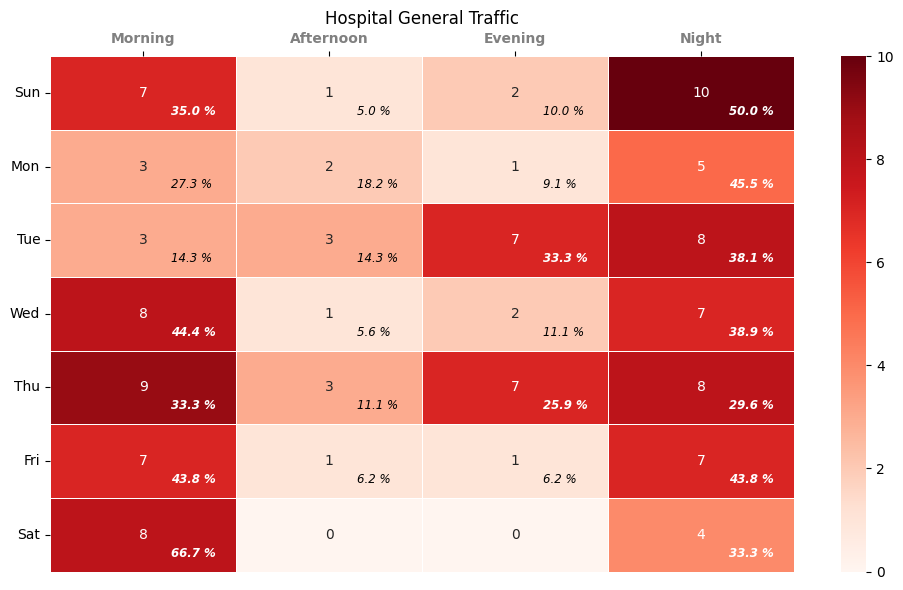

In [12]:
def general_traffic_visual():
    df = general_traffic(filtered_dataframe(start_date, end_date))
    
    # Getting half of the max value
    half_largest = (df.values.max()/2)-1
    
    # Getting the sum of each row
    daily_sum = df.sum(axis=1)

    # Getting the percentage representations
    percent_df = df.apply(lambda x: (x/daily_sum)*100).round(1)
    
    fig, ax = plt.subplots(figsize=(10,6))
    sns.heatmap(data=df, annot=True, cmap='Reds', linewidths=.6)
    ax.set_title("Hospital General Traffic")

    # Annotating with percentages
    for i, day in enumerate(percent_df.index):
        for k, perc_val in enumerate(percent_df.loc[day]):
            no_of_patients = df.iloc[i,k]
            if no_of_patients != 0:
                if no_of_patients >= half_largest:
                    ax.text(x=k+.65, y=i+.75,s=f'{perc_val} %', va='center', ha='left', color='white', fontsize=8.5, style='oblique', weight='bold')
                else:
                    ax.text(x=k+.65, y=i+.75,s=f'{perc_val} %', va='center', ha='left', style='oblique', fontsize=8.5)

    # Redefine the font for x axis labels and Move the x axis to the top
    ax.set_xticklabels(labels=ax.get_xticklabels(), fontdict=dict(color='grey', weight='bold'))
    ax.xaxis.set_ticks_position('top')
    plt.yticks(rotation='horizontal')
    plt.tight_layout()
    plt.close()
    return fig

general_traffic_visual()

Visualize with a bar graph

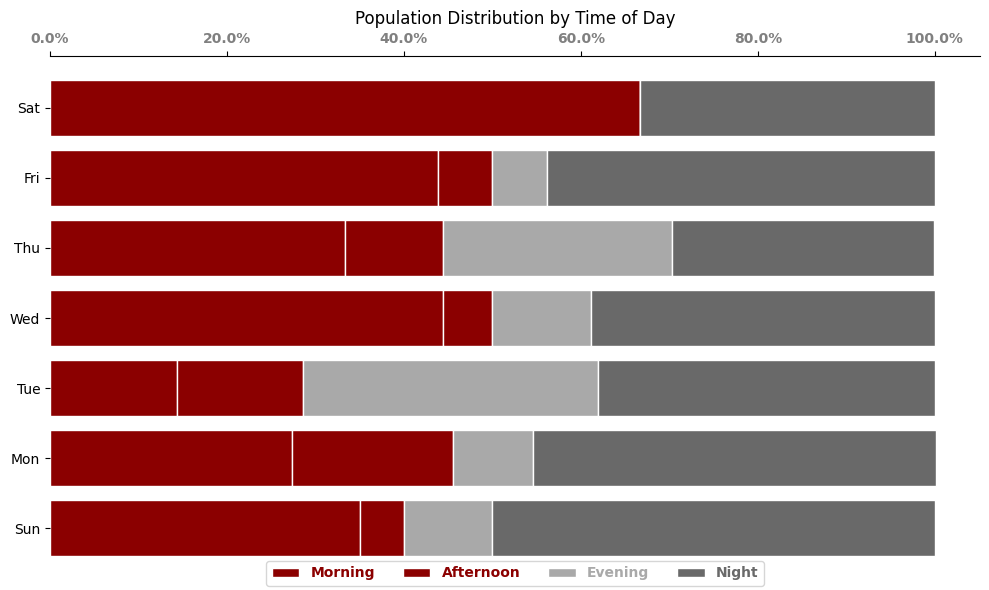

In [13]:
def general_traffic_bar_visual():
    # Fetching the data from the initial function
    df = general_traffic(filtered_dataframe(start_date, end_date))

    # Getting the sum of each row
    daily_sum = df.sum(axis=1)

    # Getting the percentage representations
    percent_df = df.apply(lambda x: (x/daily_sum)*100).round(1)

    fig, ax = plt.subplots(figsize=(10,6))

    # Define shades of gray for each time period, with the brightest color for the longest bar region
    colors = ['#8B0000', '#8B0000', '#a9a9a9', '#696969']

    # Calculate cumulative sum for stacked bar positions
    cumulative = np.zeros(len(df.index))

    # Plot the stacked horizontal bar chart with custom colors
    bars = []
    for i, time_period in enumerate(['Morning', 'Afternoon', 'Evening', 'Night']):
        bar = ax.barh(percent_df.index, percent_df[time_period], left=cumulative, label=time_period, color=colors[i], edgecolor='white')
        bars.append(bar)
        cumulative += percent_df[time_period]
        
        # Annotate each bar segment
        # for bar in bars:
        #     width = bar.get_width()
        #     if width > 0:
        #         ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{width:.1f}%', ha='center', va='center', color='white', weight='bold')

    # Add labels and title
    ax.set_title('Population Distribution by Time of Day')

    # Removing the spines
    ax.spines[['left', 'right', 'bottom']].set_color(None)

    # Redefining the x-tick lables to include %
    ax.set_xticks(ax.get_xticks()[:-1])
    ax.set_xticklabels(labels=ax.get_xticklabels(), fontdict=dict(color='grey', weight='bold'))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}%'))

    # Move x-axis to the top
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

    # Defining the legend
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=4)
    legend = Legend(ax, [b[0] for b in bars], [bar.get_label() for bar in bars], loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=5)
    for text, color in zip(legend.get_texts(), colors):
        text.set_color(color)
        text.set_weight('bold')
    ax.add_artist(legend)
    plt.tight_layout()
    plt.close()
    return fig

general_traffic_bar_visual()

> #### b. Population on various departments in different days of the week

In [14]:
def departmental_population(df):
    dep_pop_df = df.where(df['department_referral'] != 'Unspecified').groupby(['day', 'department_referral']).size().reset_index(name='patients')
    pivoted_dep_pop_df = dep_pop_df.pivot_table(values='patients', index='department_referral', columns='day').fillna(0).astype('int')
    pivoted_dep_pop_df.index.name = None
    pivoted_dep_pop_df.columns.name = None
    pivoted_dep_pop_df = pivoted_dep_pop_df[['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']]
    return pivoted_dep_pop_df

departmental_population(filtered_dataframe(start_date, end_date))

,Sun,Mon,Tue,Wed,Thu,Fri,Sat
Cardiology,0,0,0,0,2,0,1
Gastroenterology,0,0,0,0,0,1,0
General Practice,5,3,6,5,7,4,3
Neurology,0,0,0,0,3,0,2
Orthopedics,4,1,3,3,3,2,1
Physiotherapy,0,1,2,0,1,0,0
Renal,0,0,0,0,0,1,0


Visualizing the above data

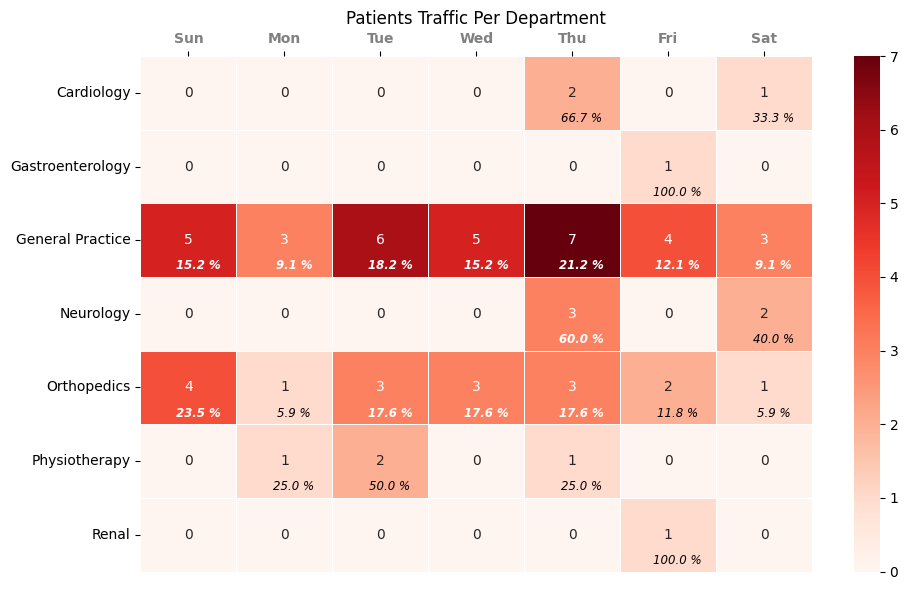

In [15]:
def department_population_visual():
    df = departmental_population(filtered_dataframe(start_date, end_date))
    
    # Getting half of the max value
    half_largest = (df.values.max()/2)-1
    
    # Getting the sum of each row
    daily_sum = df.sum(axis=1)

    # Getting the percentage representations
    percent_df = df.apply(lambda x: (x/daily_sum)*100).round(1)
    
    fig, ax = plt.subplots(figsize=(10,6))
    sns.heatmap(data=df, annot=True, linewidths=.6, cmap='Reds')
    ax.set_title("Patients Traffic Per Department")

    # Annotating with percentages
    for i, department in enumerate(percent_df.index):
        for k, perc_val in enumerate(percent_df.loc[department]):
            no_of_patients = df.iloc[i,k]
            if no_of_patients != 0:
                if no_of_patients >= half_largest:
                    ax.text(x=k+.60, y=i+.76,s=f'{perc_val} %', va='top', ha='center', color='white', fontsize=8.5, style='oblique', weight='bold')
                else:
                    ax.text(x=k+.60, y=i+.76,s=f'{perc_val} %', va='top', ha='center', style='oblique', fontsize=8.5)

    # Make the x and y axis ticks bold
    ax.set_xticklabels(labels=ax.get_xticklabels(), fontdict=dict(weight='bold', color='grey'))
    # ax.set_yticklabels(labels=ax.get_yticklabels(), fontdict=dict(style='italic'))

    # Move the x axis to the top
    ax.xaxis.set_ticks_position('top')

    plt.tight_layout()
    plt.close()
    return fig

department_population_visual()

> #### c. Population on various departments in different times of the day

In [16]:
def timely_departmental_population(df):
    dep_pop_df = df.where(df['department_referral'] != 'Unspecified').groupby(['time_of_day', 'department_referral']).size().reset_index(name='patients')
    pivoted_dep_pop_df = dep_pop_df.pivot_table(values='patients', index='department_referral', columns='time_of_day').fillna(0).astype('int')
    pivoted_dep_pop_df.index.name = None
    pivoted_dep_pop_df.columns.name = None
    pivoted_dep_pop_df = pivoted_dep_pop_df[['Morning', 'Afternoon', 'Evening', 'Night']]
    return pivoted_dep_pop_df

timely_departmental_population(filtered_dataframe(start_date, end_date))

,Morning,Afternoon,Evening,Night
Cardiology,1,0,2,0
Gastroenterology,0,0,0,1
General Practice,10,1,5,17
Neurology,2,0,1,2
Orthopedics,4,3,2,8
Physiotherapy,2,0,2,0
Renal,0,0,1,0


Visualizing the above data

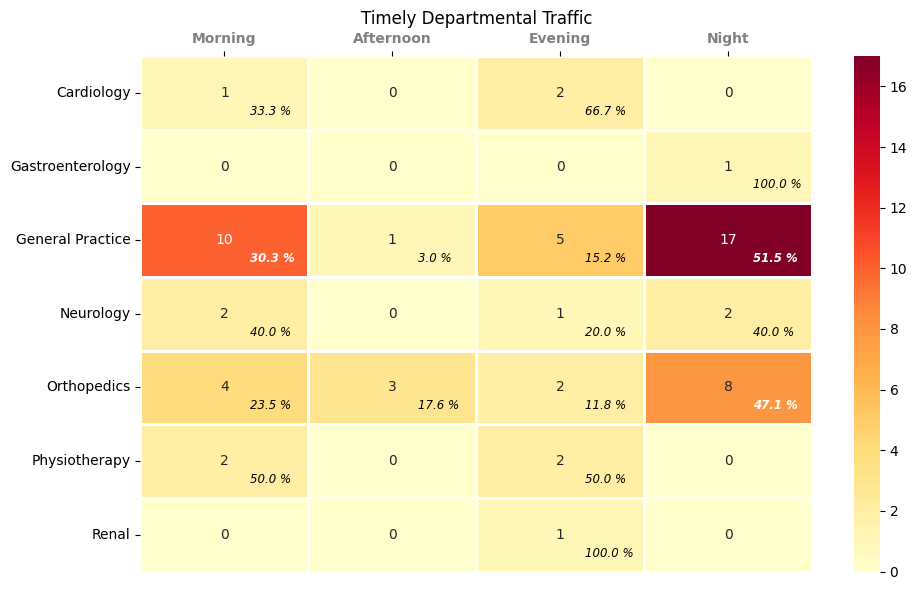

In [17]:
def timely_departmental_population_visual():
    df = timely_departmental_population(filtered_dataframe(start_date, end_date))
    
    # Getting half of the max value
    half_largest = (df.values.max()/2)-1
    
    # Getting the sum of each row
    daily_sum = df.sum(axis=1)

    # Getting the percentage representations
    percent_df = df.apply(lambda x: (x/daily_sum)*100).round(1)
    
    fig, ax = plt.subplots(figsize=(10,6))
    sns.heatmap(data=df, annot=True, linewidths=1, cmap='YlOrRd')
    ax.set_title("Timely Departmental Traffic")

    # Annotating with percentages
    for i, department in enumerate(percent_df.index):
        for k, perc_val in enumerate(percent_df.loc[department]):
            no_of_patients = df.iloc[i,k]
            if no_of_patients != 0:
                if no_of_patients >= half_largest:
                    ax.text(x=k+.65, y=i+.75,s=f'{perc_val} %', va='center', ha='left', color='white', fontsize=8.5, style='oblique', weight='bold')
                else:
                    ax.text(x=k+.65, y=i+.75,s=f'{perc_val} %', va='center', ha='left', style='oblique', fontsize=8.5)

    # Set font for both x and y axes
    ax.set_xticklabels(ax.get_xticklabels(), fontdict=dict(color='grey', weight='bold'))

    # Move the x tick labels to the top
    ax.xaxis.set_ticks_position('top')

    plt.tight_layout()
    plt.close()
    return fig

timely_departmental_population_visual()

### Track The Patients Satisfaction Rate

> #### a. Overall Satisfaction score distribution

In [18]:
def general_satisfation(df):
    sat_df = df.groupby('sat_comment').size().reset_index(name='patients')
    sat_df.set_index('sat_comment', inplace=True)
    sat_df.index.name = None
    sat_df = sat_df.reindex(['Very Dissatisfied', 'Dissatisfied', 'Neutral', 'Satisfied', 'Very Satisfied'])

    # Total patients
    total_patients = sat_df.sum()

    # Getting percentage representation
    sat_df['percentage'] = sat_df['patients'].apply(lambda count: round((count/total_patients * 100), 1))
    return sat_df

general_satisfation(filtered_dataframe(start_date, end_date))

,patients,percentage
Very Dissatisfied,32,25.6
Dissatisfied,22,17.6
Neutral,18,14.4
Satisfied,24,19.2
Very Satisfied,29,23.2


Visualizing the above data

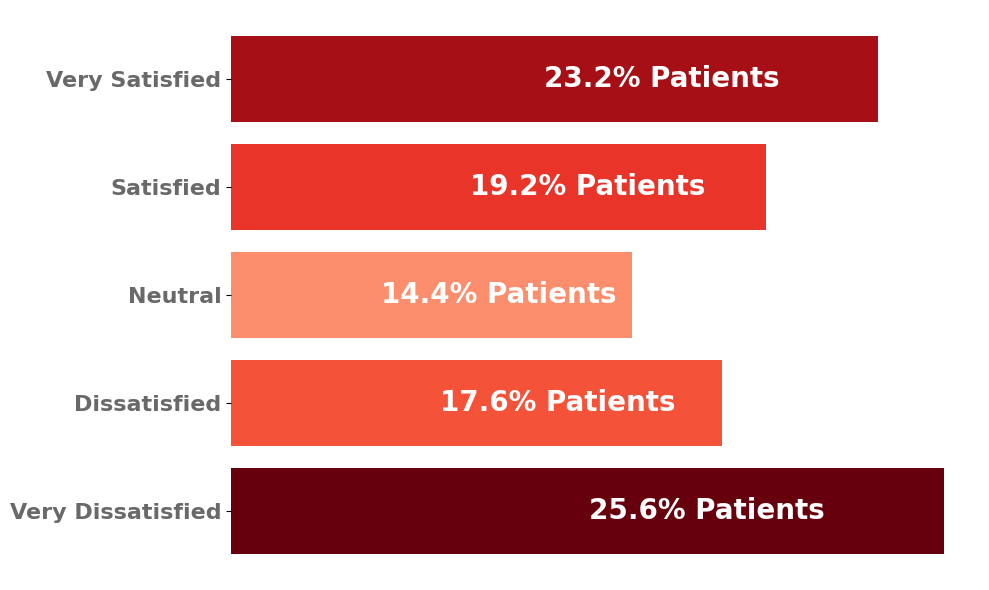

In [19]:
def general_satisfaction_figure(df):
    # Choose a colormap
    cmap = plt.get_cmap('Reds')

    # Normalize the values for color mapping
    norm = plt.Normalize(df['patients'].min()-(df['patients'].min()/2), df['patients'].max())
    
    fig, ax = plt.subplots(figsize=(10,6))
    # fig, ax = plt.subplots(figsize=(10,4))
    ax.barh(data=df[['patients']], y=df.index, width=df.patients, color=cmap(norm(df['patients'])))
    ax.spines[['top', 'bottom', 'right', 'left']].set_color(None)

    # Annotating the bars
    for i, (comment, percent) in enumerate(zip(df.index, df.percentage)):
        if percent > 5:
            ax.text(x=df.patients.iloc[i]/1.5, y=i ,s=f"{percent}% Patients", va='center', ha='center', color='white', fontsize=20, weight='bold')
        else:
            ax.text(x=df.patients.iloc[i]+2.5, y=i ,s=f"{percent}% Patients", va='center', ha='center', color='grey', fontsize=20, weight='bold')

    # ax.set_title('General Patients Satisfaction')
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(fontdict=dict(color='#696969', weight='bold'), labels=ax.get_yticklabels(), fontsize=16)

    # Removing the x axis
    ax.set_xticklabels([])
    ax.set_xticks([])
    
    plt.tight_layout()
    plt.close()
    return fig

general_satisfaction_figure(general_satisfation(filtered_dataframe(start_date, end_date)))

> #### b. Satisfaction Score Distribution Per Department

In [20]:
def dep_sat_distribution(df):
    # We will ignore the reviews for records with unspecified department
    avg_df = df.where(df.department_referral != 'Unspecified').groupby(['department_referral', 'sat_comment']).size().reset_index(name='patients')
    pivoted_avg_df = avg_df.pivot_table(values='patients', index='department_referral', columns='sat_comment').fillna(0).astype('int')
    pivoted_avg_df.columns.name = None
    pivoted_avg_df.index.name = None
    # pivoted_avg_df.index.name = 'Comment'
    pivoted_avg_df = pivoted_avg_df[['Very Dissatisfied', 'Dissatisfied', 'Neutral', 'Satisfied', 'Very Satisfied']]

    return pivoted_avg_df

dep_sat_distribution(filtered_dataframe(start_date, end_date))

,Very Dissatisfied,Dissatisfied,Neutral,Satisfied,Very Satisfied
Cardiology,0,0,0,2,1
Gastroenterology,0,1,0,0,0
General Practice,9,4,5,6,9
Neurology,2,0,1,0,2
Orthopedics,4,3,2,5,3
Physiotherapy,2,0,0,0,2
Renal,0,0,0,0,1


Visualizing the above data

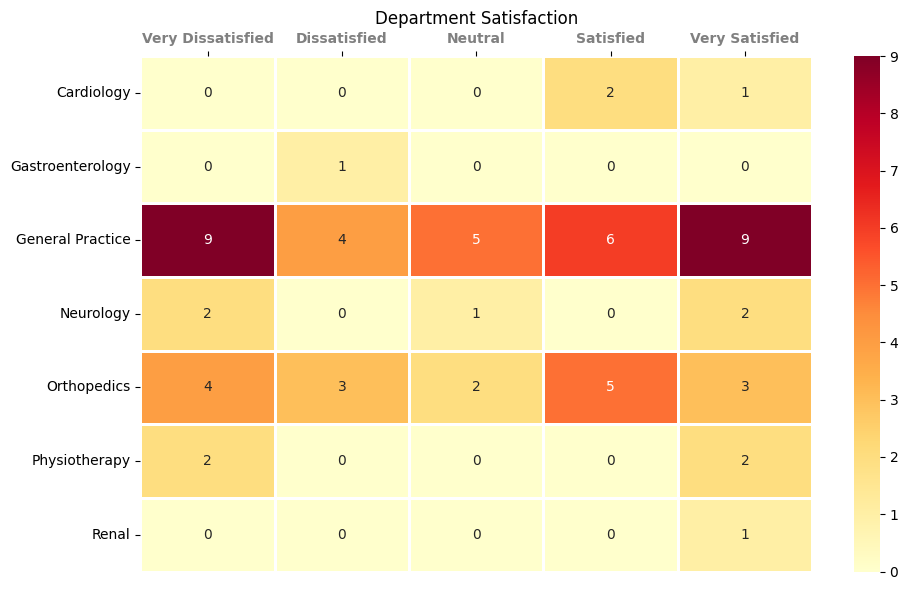

In [21]:
def dep_sat_distribution_visual():
    df = dep_sat_distribution(filtered_dataframe(start_date, end_date))
    fig, ax = plt.subplots(figsize=(10,6))
    sns.heatmap(data=df, annot=True, cmap='YlOrRd', linewidths=1)
    ax.set_title('Department Satisfaction')

    # set the font attributes of x and y axes
    ax.set_xticklabels(labels=ax.get_xticklabels(), fontdict=dict(color='grey', weight='bold'))
    # ax.set_yticklabels(labels=ax.get_yticklabels(), fontdict=dict(color='grey'))

    # Move the x axis to the top
    ax.xaxis.set_ticks_position('top')

    plt.tight_layout()
    plt.close()
    return fig

dep_sat_distribution_visual()

Vialize in a bar format

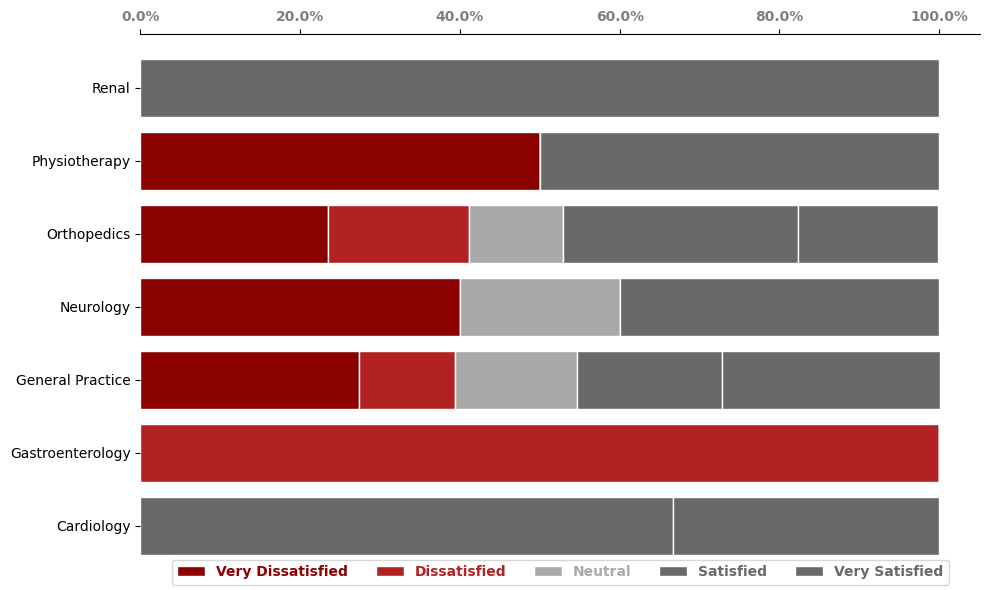

In [73]:
def dep_sat_disstribution_bar_visual(df):

    # Getting the sum of each row
    daily_sum = df.sum(axis=1)

    # Getting the percentage representations
    percent_df = df.apply(lambda x: (x/daily_sum)*100).round(1)

    fig, ax = plt.subplots(figsize=(10,6))

    # Define shades of gray for each time period, with the brightest color for the longest bar region
    # greys '#a9a9a9', '#696969'
    colors = ['#8B0000', '#B22222', '#a9a9a9', '#696969', '#696969']

    # Calculate cumulative sum for stacked bar positions
    cumulative = np.zeros(len(percent_df.index))

    # Plot the stacked horizontal bar chart with custom colors
    bars = []
    for i, time_period in enumerate(['Very Dissatisfied', 'Dissatisfied', 'Neutral', 'Satisfied', 'Very Satisfied']):
        bar = ax.barh(percent_df.index, percent_df[time_period], left=cumulative, label=time_period, color=colors[i], edgecolor='white')
        bars.append(bar)
        cumulative += percent_df[time_period]

    # Add labels and title
    # ax.set_title('Patients Departmental Satisfaction', loc='left')

    # Removing the spines
    ax.spines[['left', 'right', 'bottom']].set_color(None)

    # Redefining the x-tick lables to include %
    ax.set_xticks(ax.get_xticks()[:-1])
    ax.set_xticklabels(labels=ax.get_xticklabels(), fontdict=dict(color='grey', weight='bold'))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}%'))

    # Move x-axis to the top
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

    # Defining the legend
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=5)
    legend = Legend(ax, [b[0] for b in bars], [bar.get_label() for bar in bars], loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=5)
    for text, color in zip(legend.get_texts(), colors):
        text.set_color(color)
        text.set_weight('bold')
    ax.add_artist(legend)
    plt.tight_layout()
    plt.close()
    return fig

dep_sat_disstribution_bar_visual(dep_sat_distribution(filtered_dataframe(start_date, end_date)))

> #### c. Avarage Departmental Satisfaction

In [23]:
def avg_dep_satisfaction(df):
    avg_df = df[['department_referral','patient_sat_score']].where(df.department_referral != 'Unspecified').groupby('department_referral').mean().round(1)
    avg_df.rename(columns={'patient_sat_score': 'score'}, inplace=True)
    avg_df.index.name = None
    commented_avg_df = avg_df.assign(
        comment=[
            (
                "Very Dissatisfied" if score <= 2 else
                "Dissatisfied" if score <= 4 else
                "Neutral" if score <= 6 else
                "Satisfied" if score <= 8 else
                "Very Satisfied"
            ) for score in avg_df.score
        ]
    )
    return commented_avg_df

avg_dep_satisfaction(filtered_dataframe(start_date, end_date))

,score,comment
Cardiology,8.0,Satisfied
Gastroenterology,3.0,Dissatisfied
General Practice,5.6,Neutral
Neurology,5.0,Neutral
Orthopedics,5.4,Neutral
Physiotherapy,5.2,Neutral
Renal,10.0,Very Satisfied


Visualizing the above data

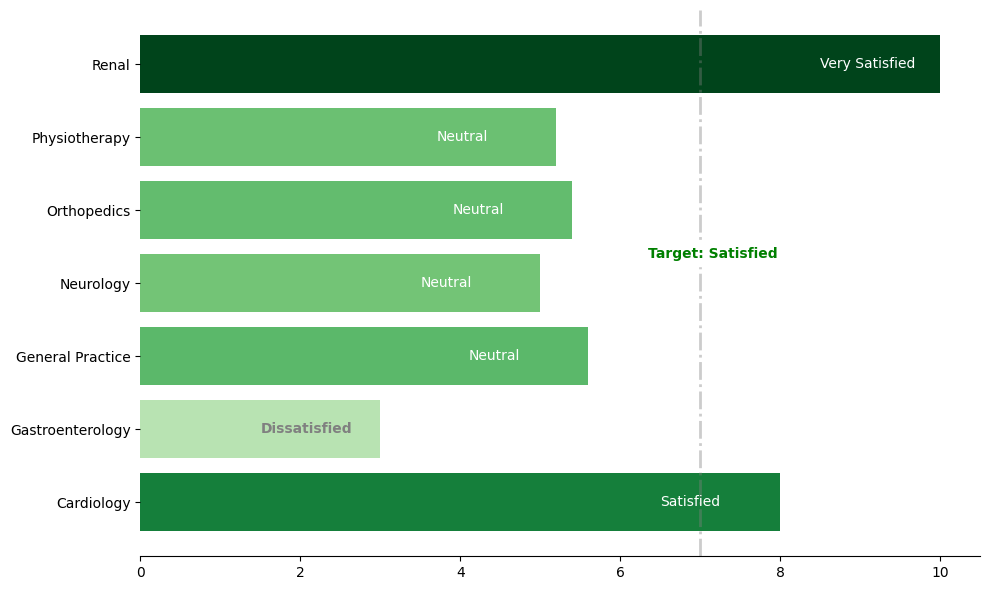

In [76]:
def avg_dep_satisfaction_visual(df):
    # Defining a color map
    cmap = plt.get_cmap('Greens')

    # Normalize the values for color mapping
    norm = plt.Normalize(0, 10)

    # Plot the figure
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(data=df, y=df.index, width=df.score, color=cmap(norm(df.score)))

    # Remove the border around the plot
    ax.spines[['left','right', 'top']].set_color(None)

    # Set a title for the graph
    # ax.set_title('Average Department Satisfaction')

    # Adding avline as a target for every department
    ax.axvline(x=7, color='grey', linestyle='-.', linewidth=2, alpha=.4)
    ax.text(7.16, 3.4, 'Target: Satisfied', color='green', va='center', ha='center', backgroundcolor='w', fontsize=10, weight='bold')

    # Annotating the bars
    for i, (score, comment) in enumerate(zip(df['score'], df['comment'])):
        if score > 3:
            ax.text(score - 1.5, i, comment, va='center', ha='left', color='white', fontsize=10)
        elif score <= 2:
            ax.text(score + .15, i, comment, va='center', ha='left', color='grey', fontsize=10, weight='bold')
        else:
            ax.text(score - 1.5, i, comment, va='center', ha='left', color='grey', fontsize=10, weight='bold')

    plt.tight_layout()
    plt.close()
    return fig
    
avg_dep_satisfaction_visual(avg_dep_satisfaction(filtered_dataframe(start_date, end_date)))

> #### d. Overall average satisfaction

In [25]:
def overall_avg_satisfaction(df):
    avg_df = df['patient_sat_score'].mean()
    return avg_df

overall_avg_satisfaction(filtered_dataframe(start_date, end_date))

np.float64(5.312)

### Tracking The Patients Waiting Time

> #### a. Overall Average Waiting Time

In [26]:
def overall_avg_wait_time(df):
    avg_wait_time = df['patient_waittime'].mean()
    return avg_wait_time

overall_avg_wait_time(filtered_dataframe(start_date, end_date))

np.float64(32.76)

> #### b. Average Waittime in Different Times of The Day across the week

In [27]:
def avg_timely_waittime(df):
    avg_waittime = df[['day', 'time_of_day', 'patient_waittime']].groupby(['day', 'time_of_day'], as_index=False).mean().round(1)
    pivoted_avg_waittime = avg_waittime.pivot_table(values='patient_waittime', columns='time_of_day', index='day')
    pivoted_avg_waittime.columns.name = None
    pivoted_avg_waittime = pivoted_avg_waittime.reindex(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']).fillna(0)
    pivoted_avg_waittime = pivoted_avg_waittime[['Morning', 'Afternoon', 'Evening', 'Night']]

    # Adding an average daily waittime column
    # We won't use the averages to get the grand average as the commented line suggests
    # pivoted_avg_waittime['Daily Avg.'] = pivoted_avg_waittime.mean(axis=1).round(1)
    # We will get the average from the grand dataset
    grand_avg = df[['day', 'patient_waittime']].groupby('day', as_index=False).mean().round(1)
    grand_avg.set_index('day', inplace=True)
    final_avg_df = pivoted_avg_waittime.merge(grand_avg, on='day')
    final_avg_df.index.name = None
    final_avg_df.rename(columns={'patient_waittime': 'DailyAvg.'}, inplace=True)
    return final_avg_df

avg_timely_waittime(filtered_dataframe(start_date, end_date))

,Morning,Afternoon,Evening,Night,DailyAvg.
Sun,27.9,54.0,32.5,35.8,33.6
Mon,28.0,30.5,11.0,38.4,31.6
Tue,29.3,34.7,26.0,33.9,30.7
Wed,26.9,13.0,41.0,33.1,30.1
Thu,30.1,45.7,33.6,42.4,36.4
Fri,27.6,26.0,28.0,30.6,28.8
Sat,40.9,0.0,0.0,29.5,37.1


Visualizing the above data

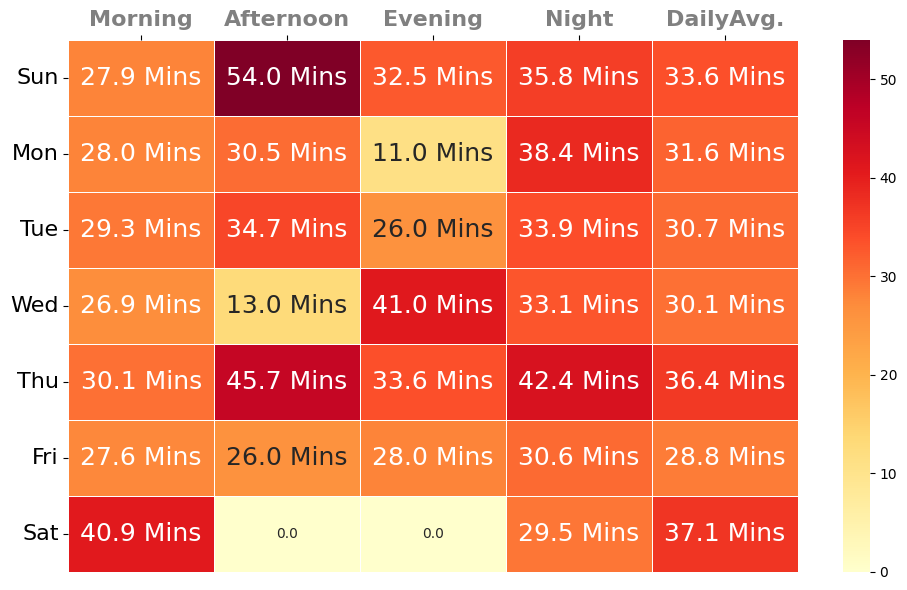

In [109]:
def avg_timely_waittime_visual(df):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.heatmap(data=df, annot=True, linewidths=.6, cmap='YlOrRd', fmt='.1f')
    for t in ax.texts:
        n = t.get_text()
        if float(n) > 0:
            t.set_text(n + " Mins")
            t.set_fontsize(18)
    # ax.set_title('Avarage Patients Waittime')

    # Set the font attribute of the tick labels
    ax.set_xticklabels(ax.get_xticklabels(), fontdict=dict(color='grey', weight='bold'), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)

    # Move the x axis to the top
    ax.xaxis.set_ticks_position('top')
    plt.yticks(rotation='horizontal')
    plt.tight_layout()
    plt.close()
    return fig

avg_timely_waittime_visual(avg_timely_waittime(filtered_dataframe(start_date, end_date)))

> #### c. Average waittime per department

This is the average in a week

In [29]:
def departmental_waittime(df):
    dep_waittime_df = df[['department_referral', 'day', 'patient_waittime']].where(df.department_referral != 'Unspecified').groupby(['department_referral', 'day']).mean().round(1)
    piv_dep_waittime_df = dep_waittime_df.pivot_table(values='patient_waittime', columns='day', index='department_referral').fillna(0)
    piv_dep_waittime_df.columns.name = None
    piv_dep_waittime_df = piv_dep_waittime_df[['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']]

    # Add the final avg for the whole week
    grand_avg = df[['department_referral', 'patient_waittime']].where(df.department_referral != 'Unspecified').groupby('department_referral', as_index=False).mean().round(1)
    grand_avg.set_index('department_referral', inplace=True)
    final_avg_df = piv_dep_waittime_df.merge(grand_avg, on='department_referral')
    final_avg_df.index.name = None
    final_avg_df.rename(columns={'patient_waittime': 'TotalAvg.'}, inplace=True)
    return final_avg_df

departmental_waittime(filtered_dataframe(start_date, end_date))

,Sun,Mon,Tue,Wed,Thu,Fri,Sat,TotalAvg.
Cardiology,0.0,0.0,0.0,0.0,25.5,0.0,11.0,20.7
Gastroenterology,0.0,0.0,0.0,0.0,0.0,16.0,0.0,16.0
General Practice,28.4,41.7,25.0,37.2,36.6,21.0,37.3,32.0
Neurology,0.0,0.0,0.0,0.0,27.3,0.0,53.5,37.8
Orthopedics,24.5,38.0,46.3,22.0,43.0,30.5,30.0,33.0
Physiotherapy,0.0,11.0,36.5,0.0,13.0,0.0,0.0,24.2
Renal,0.0,0.0,0.0,0.0,0.0,28.0,0.0,28.0


Visualize The above data

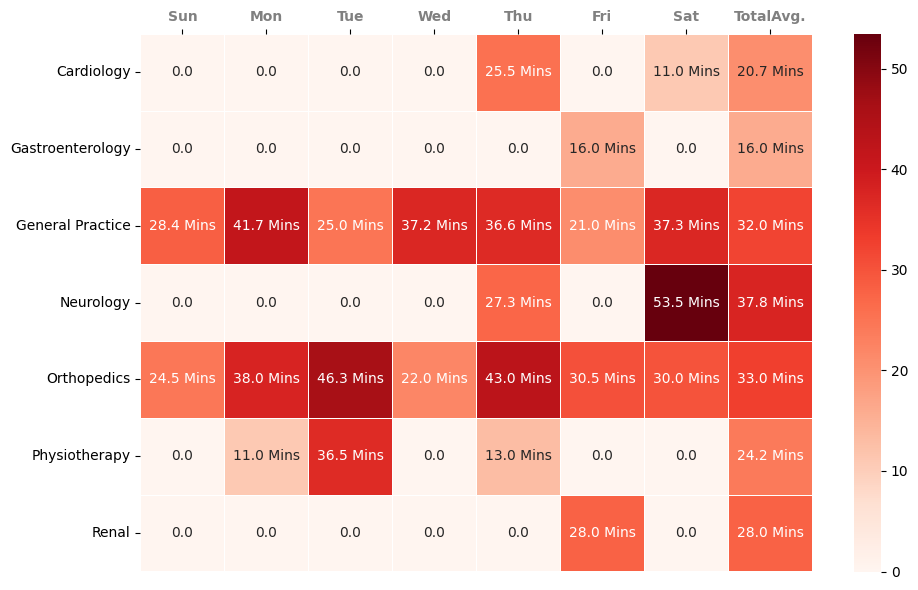

In [117]:
def departmental_waittime_visual(df):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.heatmap(data=df, annot=True, linewidths=.6, cmap='Reds', fmt='.1f')
    for t in ax.texts:
        n = t.get_text()
        if float(n) > 0:
            t.set_text(n + " Mins")
    # ax.set_title('Weekly Average for Patients Waittime per department')

    # Define font attributes for x ticks
    ax.set_xticklabels(labels=ax.get_xticklabels(), fontdict=dict(color='grey', weight='bold'))

    # Move x axis to the top
    ax.xaxis.set_ticks_position('top')
    plt.tight_layout()
    plt.close()
    return fig

departmental_waittime_visual(departmental_waittime(filtered_dataframe(start_date, end_date)))

This is the average in a day

In [31]:
def daily_departmental_waittime(df):
    dep_waittime_df = df[['department_referral', 'time_of_day', 'patient_waittime']].where(df.department_referral != 'Unspecified').groupby(['department_referral', 'time_of_day']).mean().round(1)
    piv_dep_waittime_df = dep_waittime_df.pivot_table(values='patient_waittime', columns='time_of_day', index='department_referral')
    piv_dep_waittime_df.columns.name = None
    piv_dep_waittime_df.index.name = None
    piv_dep_waittime_df = piv_dep_waittime_df[['Morning', 'Afternoon', 'Evening', 'Night']]

    # Add the final avg for the whole week
    piv_dep_waittime_df['DailyAvg.'] = piv_dep_waittime_df.mean(axis=1).round(1)
    piv_dep_waittime_df.fillna(0, inplace=True)
    return piv_dep_waittime_df

daily_departmental_waittime(filtered_dataframe(start_date, end_date))

,Morning,Afternoon,Evening,Night,DailyAvg.
Cardiology,11.0,0.0,25.5,0.0,18.2
Gastroenterology,0.0,0.0,0.0,16.0,16.0
General Practice,31.5,44.0,30.6,31.9,34.5
Neurology,29.5,0.0,14.0,58.0,33.8
Orthopedics,27.8,34.7,48.5,31.1,35.5
Physiotherapy,27.5,0.0,21.0,0.0,24.2
Renal,0.0,0.0,28.0,0.0,28.0


Visualizing the above data

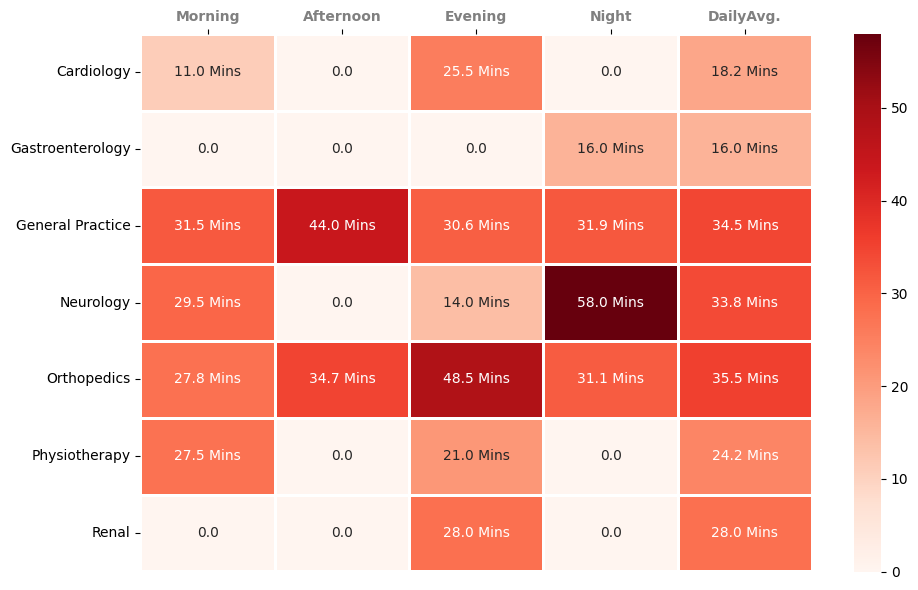

In [111]:
def daily_department_waittime_visual(df):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.heatmap(data=df, annot=True, linewidths=1, cmap="Reds", fmt='.1f')
    for t in ax.texts:
        n = t.get_text()
        if float(n) > 0:
            t.set_text(n + " Mins")
    # ax.set_title("Patients Average Waittime Per Department")

    # Define the fonts of x axis labels
    ax.set_xticklabels(labels=ax.get_xticklabels(), fontdict=dict(color='grey', weight='bold'))

    # Move the x axis to the top
    ax.xaxis.set_ticks_position('top')

    plt.tight_layout()
    plt.close()
    return fig

daily_department_waittime_visual(daily_departmental_waittime(filtered_dataframe(start_date, end_date)))

## Defining Callback functions

In [118]:
def update_figures(change):
    # Setting up key variables
    _start_date = start_date_widget.value
    _end_date = end_date_widget.value
    demographic_key = demographic_button.value
    df = filtered_dataframe(_start_date, _end_date)
    
    _average_waittime.value = overall_avg_wait_time(df)
    _average_satisfaction.value = overall_avg_satisfaction(df)

    # Getting the number of admitted patients and those discharged
    admission_status = patients_admission_status(df)
    admitted_patients = admission_status.where(admission_status.patient_admin_flag==True).dropna().patients.values[0]
    
    _inpatients_pop.value = admitted_patients

    discharged_patients = admission_status.where(admission_status.patient_admin_flag==False).dropna().patients.values[0]
    _discharged_patients.value = discharged_patients

    # Number of Beds
    total_beds = 200
    _number_of_beds.value = total_beds - admitted_patients

    # Total number of patients attended to
    _total_patients.value = admission_status['patients'].sum()
    
    # Demographics table
    _demographics_table.value = demographics(df, demographic_key)

    # Figures
    _general_satisfaction_df = general_satisfation(df)
    _general_satisfaction_figure_panel.object = general_satisfaction_figure(_general_satisfaction_df)
    
    _average_dep_satisfaction_df = avg_dep_satisfaction(df)
    _average_dep_satisfaction_figure_panel.object = avg_dep_satisfaction_visual(_average_dep_satisfaction_df)
    
    _dep_sat_disstribution_bar_df = dep_sat_distribution(df)
    _dep_sat_disstribution_bar_visual_figure_panel.object = dep_sat_disstribution_bar_visual(_dep_sat_disstribution_bar_df)
    
    _avg_timely_waittime_df = avg_timely_waittime(df)
    _avg_timely_waittime_figure_panel.object = avg_timely_waittime_visual(_avg_timely_waittime_df)

    _daily_department_waittime_df = daily_departmental_waittime(df)
    _daily_department_waittime_figure_panel.object = daily_department_waittime_visual(_daily_department_waittime_df)

    _departmental_waittime_df = departmental_waittime(df)
    _departmental_waittime_figure_panel.object = departmental_waittime_visual(_departmental_waittime_df)

## Defining Objects

#### Key Banner Insights

In [34]:
_average_waittime = pn.indicators.Number(
    name='<span style="color: #000000; border-left: solid red 5px; padding: 3px;">Waittime</span',
    aspect_ratio='auto', styles={"margin-bottom":"1px"},
    colors=[(15,'green'), (30, 'gold'), (45, 'orangered'), (60, 'red')], 
    format='{value:.1f}<span style="font-size: 18px;">Mins</span>',
    font_size='40px'
    # styles={"margin-right":"70px"}
)
_average_waittime

Number(aspect_ratio='auto', colors=[(15, 'green'), ...], font_size='40px', format='{value:.1f}<span s..., name='<span style="color: #..., styles={'margin-bottom': '1px'})

In [35]:
_average_satisfaction = pn.indicators.Number(
    name='<span style="color: #000000; border-left: solid red 5px; padding: 3px;">Satisfaction</span',
    aspect_ratio='auto', styles={"margin-bottom":"1px"},
    colors=[(4,'red'), (6, 'gold'), (10, 'green')], 
    format='{value:.2f}', font_size='45px', align='end'
)
_average_satisfaction

Number(align='end', aspect_ratio='auto', colors=[(4, 'red'), (6, ...], font_size='45px', format='{value:.2f}', name='<span style="color: #..., styles={'margin-bottom': '1px'})

In [36]:
_inpatients_pop = pn.indicators.Number(
    name='<span style="color: #000000; border-left: solid red 5px; padding-left: 3px;">Admitted</span',
    aspect_ratio='auto', font_size='40px', styles={"margin-bottom":"1px"},
    format='{value:.0f}<span style="font-size: 18px;">Patients</span>', 
    default_color='orangered'
)

In [37]:
_discharged_patients = pn.indicators.Number(
    name='<span style="color: #000000; border-left: solid red 5px; padding-left: 3px;">Discharged</span',
    aspect_ratio='auto', font_size='40px', styles={"margin-bottom":"1px"},
    format='{value:.0f}<span style="font-size: 18px;">Patients</span>', default_color='green'
)

In [38]:
_total_patients = pn.indicators.Number(
    name='<span style="color: #000000; border-left: solid orangered 5px; padding-left: 3px;">Registered</span',
    aspect_ratio='auto', font_size='36px', default_color='gold', 
    format='<span style="font-size: 28px;">{value:.0f}</span><span style="font-size: 18px;">Patients</span>'
)

In [39]:
_number_of_beds = pn.indicators.Number(
    aspect_ratio='auto', font_size='38px', colors=[(50,'red'), (100, 'gold'), (150, 'green')], styles={"margin-top": "-10px"},
    format='<span style="font-size: 24px; color: #000000; border-left: solid orangered 5px; padding-left: 2px;">Bed Capacity: </span><span style="font-size: 28px;">{value:.0f}</span><span style="font-size: 18px;">/200</span>'
)

Demographics Table

In [40]:
# Define CSS style for fixed column width
css = """
.tabulator-cell {
    //max-width: 150px !important;  /* Change max-width to desired fixed width */
    overflow: hidden;
    text-overflow: ellipsis;
    white-space: nowrap;
    //min-width: 150px !important;
    width: 145px !important;
}
.tabulator-header-group .tabulator-tableHolder {
    width: 290px;
}
.tabulator-col {
    //max-width: 150px !important;  /* Change max-width to desired fixed width */
    //min-width: 150px !important;
    width: 145px !important;
}
"""

_demographics_table = pn.widgets.Tabulator(
    aspect_ratio='auto', show_index=False, page_size=4, 
    pagination='remote', min_width=200, width=290, 
    sizing_mode='fixed', min_height=150, height=180, # text_align='left'
)

# Apply CSS styles
pn.config.raw_css.append(css)

Matplotlib Figures

In [119]:
_general_satisfaction_figure_panel = pn.pane.Matplotlib(
    aspect_ratio='auto', height=230,
    max_width=500,
)
_average_dep_satisfaction_figure_panel = pn.pane.Matplotlib(
    aspect_ratio='auto', height=400, sizing_mode='stretch_width',
    min_width=500
)
_dep_sat_disstribution_bar_visual_figure_panel = pn.pane.Matplotlib(
    aspect_ratio='auto', height=400, sizing_mode='stretch_width',
    min_width=500
)
_avg_timely_waittime_figure_panel = pn.pane.Matplotlib(
    aspect_ratio='auto', height=230,
    max_width=500
)
_daily_department_waittime_figure_panel = pn.pane.Matplotlib(
    aspect_ratio='auto', height=400, sizing_mode='stretch_width',
    min_width=500
)
_departmental_waittime_figure_panel = pn.pane.Matplotlib(
    aspect_ratio='auto', height=400, sizing_mode='stretch_width',
    min_width=500
)

Configuring Listeners

In [42]:
start_date_widget.observe(update_figures, names='value')
end_date_widget.observe(update_figures, names='value')
# demographic_button.observe(update_figures, names='value')

Handling the demographics button

In [43]:
demographic_button.param.watch(update_figures, 'value')

Watcher(inst=RadioButtonGroup(aspect_ratio='auto', button_type='danger', options=['Race', 'Age', 'Gender'], value='Race', width=290), cls=<class 'panel.widgets.select.RadioButtonGroup'>, fn=<function update_figures at 0x7f211a9bb380>, mode='args', onlychanged=True, parameter_names=('value',), what='value', queued=False, precedence=0)

Initial Plots

In [44]:
update_figures(None)

In [45]:
start_date_widget

DatePicker(value=Timestamp('2020-09-30 23:44:00'), description='Start date:', layout=Layout(width='210px'), st…

In [46]:
end_date_widget

DatePicker(value=Timestamp('2020-10-30 23:44:00'), description='End date:', layout=Layout(width='210px'), step…

## Dashboard Layout

### Section 1

In [110]:
tabs = pn.Tabs(
    (
        "Main Board",
        # The first header row with highlight stats
        pn.Row(
            pn.Column(
                pn.Row(
                    # First section with the summary output
                    pn.Column(
                        pn.pane.Markdown("<h3>Overall Summary</h3>", styles=dict(color='red')),
                        pn.Row(
                            pn.Column(
                                _average_waittime
                            ),
                            pn.Column(
                                _average_satisfaction
                            )
                        ),
                        pn.Row(
                            pn.Column(
                                _inpatients_pop
                            ),
                            pn.Column(
                                _discharged_patients
                            )
                        ), styles={"border-right": "1px solid red"}
                    ),
                    # Demographics section
                    pn.Column(
                        pn.pane.Markdown("<h3>Patients Demographics</h3>", styles=dict(color='red')),
                        pn.panel(demographic_button, max_width=5, sizing_mode='stretch_width'),
                        _demographics_table, styles={"border-right": "1px solid red"}
                    ),
                    # Overall Satisfaction comments section
                    pn.Column(
                        pn.pane.Markdown("<h3>Overall Satisfaction Scores</h3>", styles=dict(color='red')),
                        _general_satisfaction_figure_panel, styles={"border-right": "1px solid red"}
                    ),
                    # The final figure on the first row
                    pn.Column(
                        pn.Row(
                            pn.Column(
                                pn.pane.Markdown("<h3 style='color: red'>Date Range Selector</h3>"),
                                start_date_widget, end_date_widget, styles={"margin-right": "8px"}
                            ), 
                            # title="<h3 style='color: red'>Date Range Selector</h3>", 
                            # active_header_background='white', collapsible=False, 
                            # styles={"margin-left":"8px", "margin-right": "8px"}, align='start'
                        ),
                        _total_patients, _number_of_beds
                    )
                )
            )
        )
    ),
    (
        "Second Board",
        pn.Row(
            pn.Column(
                pn.Row(
                    pn.Column(
                        pn.pane.Markdown("<h3 style='color: red'>Average Waittime Per Day</h3>"),
                        _avg_timely_waittime_figure_panel
                    ),
                    pn.Column(
                        pn.pane.Markdown("<h3 style='color: red'>Score Distribution</h3>"),
                        pn.pane.Markdown("<h6 style='color: red'>Try to replace the heatmap with the table data. Try to make it that the table has color map</h6>"),
                        # _dep_sat_disstribution_bar_visual_figure_panel
                    )
                )
            )
        )
    )
)

### Section 2

In [120]:
section2 = pn.Tabs(
    (
        "Patients Satisfaction",
        pn.Row(
            pn.Column(
                pn.Row(
                    pn.Column(
                        pn.pane.Markdown("<h3 style='color: red'>Average Satisfaction Score</h3>"),
                        _average_dep_satisfaction_figure_panel
                    ),
                    pn.Column(
                        pn.pane.Markdown("<h3 style='color: red'>Score Distribution</h3>"),
                        _dep_sat_disstribution_bar_visual_figure_panel
                    )
                )
            )
        )
    ),
    (
        "Patients Waittime",
        pn.Row(
            pn.Column(
                pn.Row(
                    pn.Column(
                        pn.pane.Markdown("<h3 style='color: red'>Average Waittime</h3>"),
                        _daily_department_waittime_figure_panel
                    ),
                    pn.Column(
                        pn.pane.Markdown("<h3 style='color: red'>Weekly Waittime</h3>"),
                        _departmental_waittime_figure_panel
                    )
                )
            )
        )
    )
)

### Main Template

In [102]:
template = pn.template.FastListTemplate(
    # Defining the header
    # header=[
        # date_picker_object
    # ],
    logo='/home/charismatic/Pictures/240_F_230648151_hvErfnvVFY4NVT14AlRxwW6GfbLqdX0B.jpg',
    header_background='maroon',
    title="Care Hospital",
    accent_base_color='red',
    main=[
        pn.Row(
            pn.Column(
                pn.pane.Markdown("<h2 style='color: red; margin-bottom: -8px;'>General Metrics</h2>"),
                tabs
            )
        ),
        pn.Row(
            pn.Column(
                pn.pane.Markdown("<h2 style='color: red; margin-bottom: -8px;'>Departmental Metrics</h2>"),
                section2
            )
        )
    ]
)

### Run server

FastListTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] TemplateActions()
    [browser_info] BrowserInfo()
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [main-139780133353296] Row
        [0] Tabs
            [0] Row
                [0] Column
                    [0] Row
                        [0] Column(styles={'border-right': '...})
                            [0] Markdown(str, styles={'color': 'red'})
                            [1] Row
                                [0] Column
                                    [0] Number(aspect_ratio='auto', colors=[(15, 'green'), ...], font_size='40px', format='{value:.1f}<span s..., name='<span style="color: #..., styles={'margin-bottom': '1px'}, value=np.float64(32.76))
                                [1] Column
                                    [0] Number(align='end', aspect_ratio='auto', colors=[(4, 'red'), (6, ...], font_size='45px', format='{value:.2f}', name='<span style="color: #..., styles={'margin-bottom': '1px'}, value=np.float64(5.312))
                            [2] Row
                                [0] Column
                                    [0] Number(aspect_ratio='auto', default_color='orangered', font_size='40px', format='{value:.0f}<span s..., name='<span style="color: #..., styles={'margin-bottom': '1px'}, value=np.float64(62.0))
                                [1] Column
                                    [0] Number(aspect_ratio='auto', default_color='green', font_size='40px', format='{value:.0f}<span s..., name='<span style="color: #..., styles={'margin-bottom': '1px'}, value=np.float64(63.0))
                        [1] Column(styles={'border-right': '...})
                            [0] Markdown(str, styles={'color': 'red'})
                            [1] RadioButtonGroup(aspect_ratio='auto', button_type='danger', options=['Race', 'Age', 'Gender'], value='Race', width=290)
                            [2] Tabulator(aspect_ratio='auto', height=180, min_height=150, min_width=200, page_size=4, pagination='remote', show_index=False, sizing_mode='fixed', value=              ..., width=290)
                        [2] Column(styles={'border-right': '...})
                            [0] Markdown(str, styles={'color': 'red'})
                            [1] Matplotlib(Figure, aspect_ratio='auto', height=230, max_width=500)
                        [3] Column
                            [0] Row
                                [0] Column(styles={'margin-right': '8px'})
                                    [0] Markdown(str)
                                    [1] IPyWidget(DatePicker)
                                    [2] IPyWidget(DatePicker)
                            [1] Number(aspect_ratio='auto', default_color='gold', font_size='36px', format='<span style="font-size: 2..., name='<span style="color: #..., value=np.int64(125))
                            [2] Number(aspect_ratio='auto', colors=[(50, 'red'), ...], font_size='38px', format='<span style="font-size: 2..., styles={'margin-top': '-10px'}, value=np.float64(138.0))
            [1] Markdown(str)
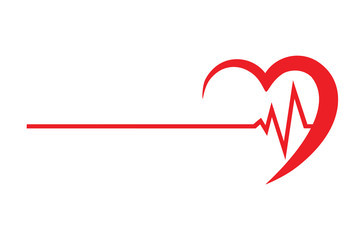
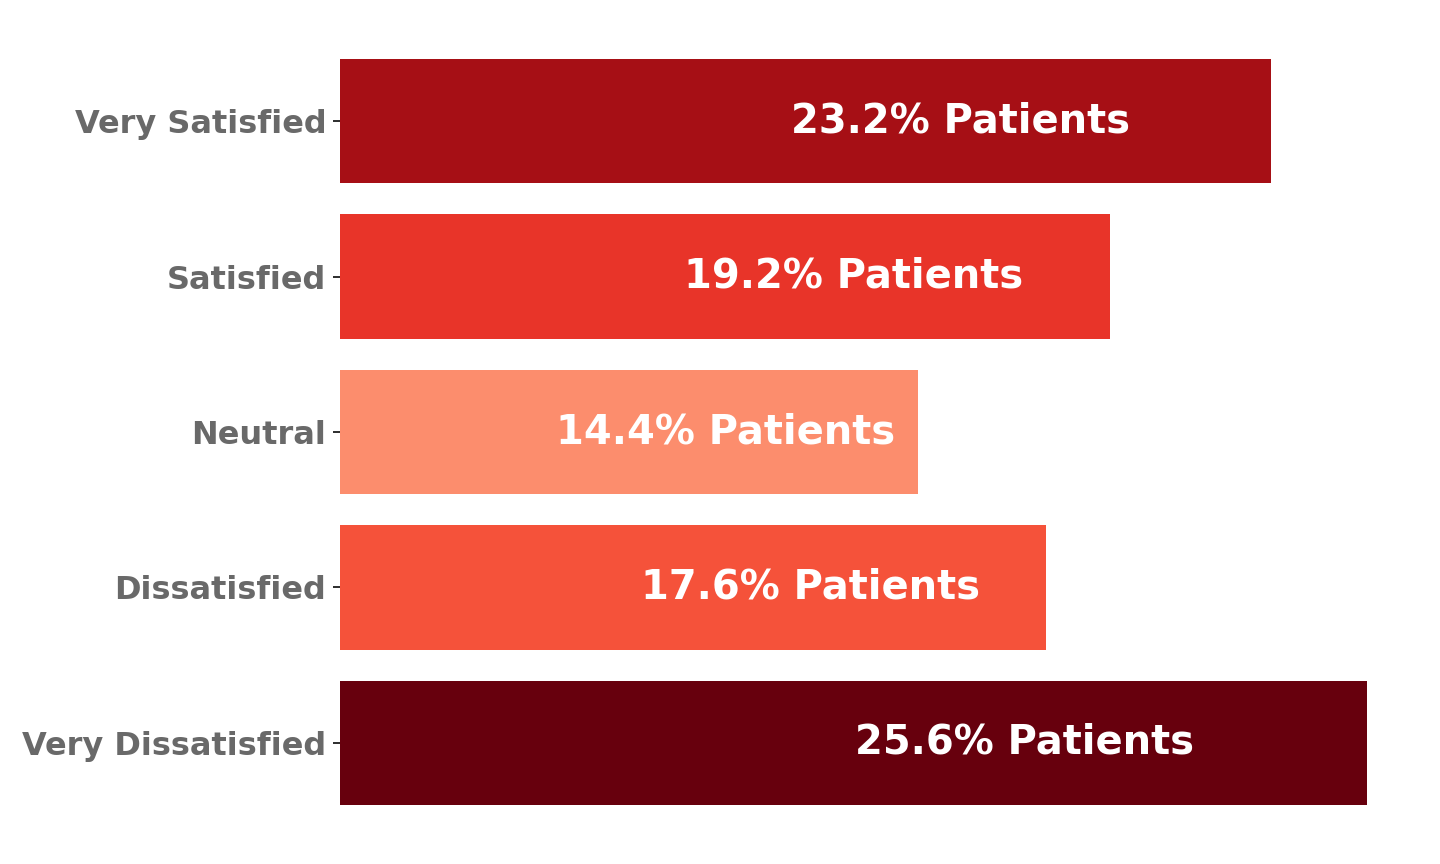

In [48]:
template.servable()